In [2]:
import gzip
from collections import defaultdict
from itertools import groupby

# schema: prec, rec, algInfo, cmpFnInfo, threshold, vpInfo, dName, info)

def openFiles(paths):
    for path in paths:
        with gzip.open(path, 'rt') as f:
            for line in f:
                yield line

def toTuples(lines):
    for line in lines:
        prec, rec, compRatio, algInfo, cmpFnInfo, threshold, vpInfo, dName, info = line.split(',')
        yield (
            float(prec),
            float(rec),
            float(compRatio),
            algInfo, 
            cmpFnInfo,
            float(threshold),
            tuple(vpInfo.split(' ')),
            dName,
            int(info)
        )

def toDicts(lines):
    for line in lines:
        prec, rec, compRatio, algInfo, cmpFnInfo, threshold, vpInfo, dName, info = line.split(',')
        yield {
            'precision': float(prec),
            'recall': float(rec),
            'compRatio': float(compRatio),
            'algorithm': algInfo, 
            'compareFn': cmpFnInfo,
            'threshold': float(threshold),
            'viewpoints': tuple(vpInfo.split(' ')),
            'dataset': dName,
            'index': int(info)
        }

def filterBy(pred):
    def f(lines):
        for line in lines:
            if pred(line):
                yield line
    return f

def count(lines):
    i = 0
    for l in lines:
        i += 1
    yield i

def apply(fn):
    def f(lines):
        for line in lines:
            yield fn(line)
    return f

def unpack(lines):
    yield from zip(*lines)

def reduceBy(fn, init):
    def f(items):
        result = init
        for item in items:
            result = fn(result, item)
        return result
    return f

def groupBy(fn):
    def f(items):
        return groupby(items, key=fn)
    return f

def createPipeline(startGen, filters):
    generator = startGen
    for filter in filters:
        generator = filter(generator)
    return generator

In [3]:
from itertools import chain, combinations
def powerset(seq):
    '''Returns a powerset of seq without the empty set'''
    s = list(seq)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s) + 1))

In [5]:
viewpoints = tuple(tuple(sorted(vp)) for vp in powerset(['midi', 'duration', 'interOnsetInterval', 'pitchContour', 'pitchInterval']))

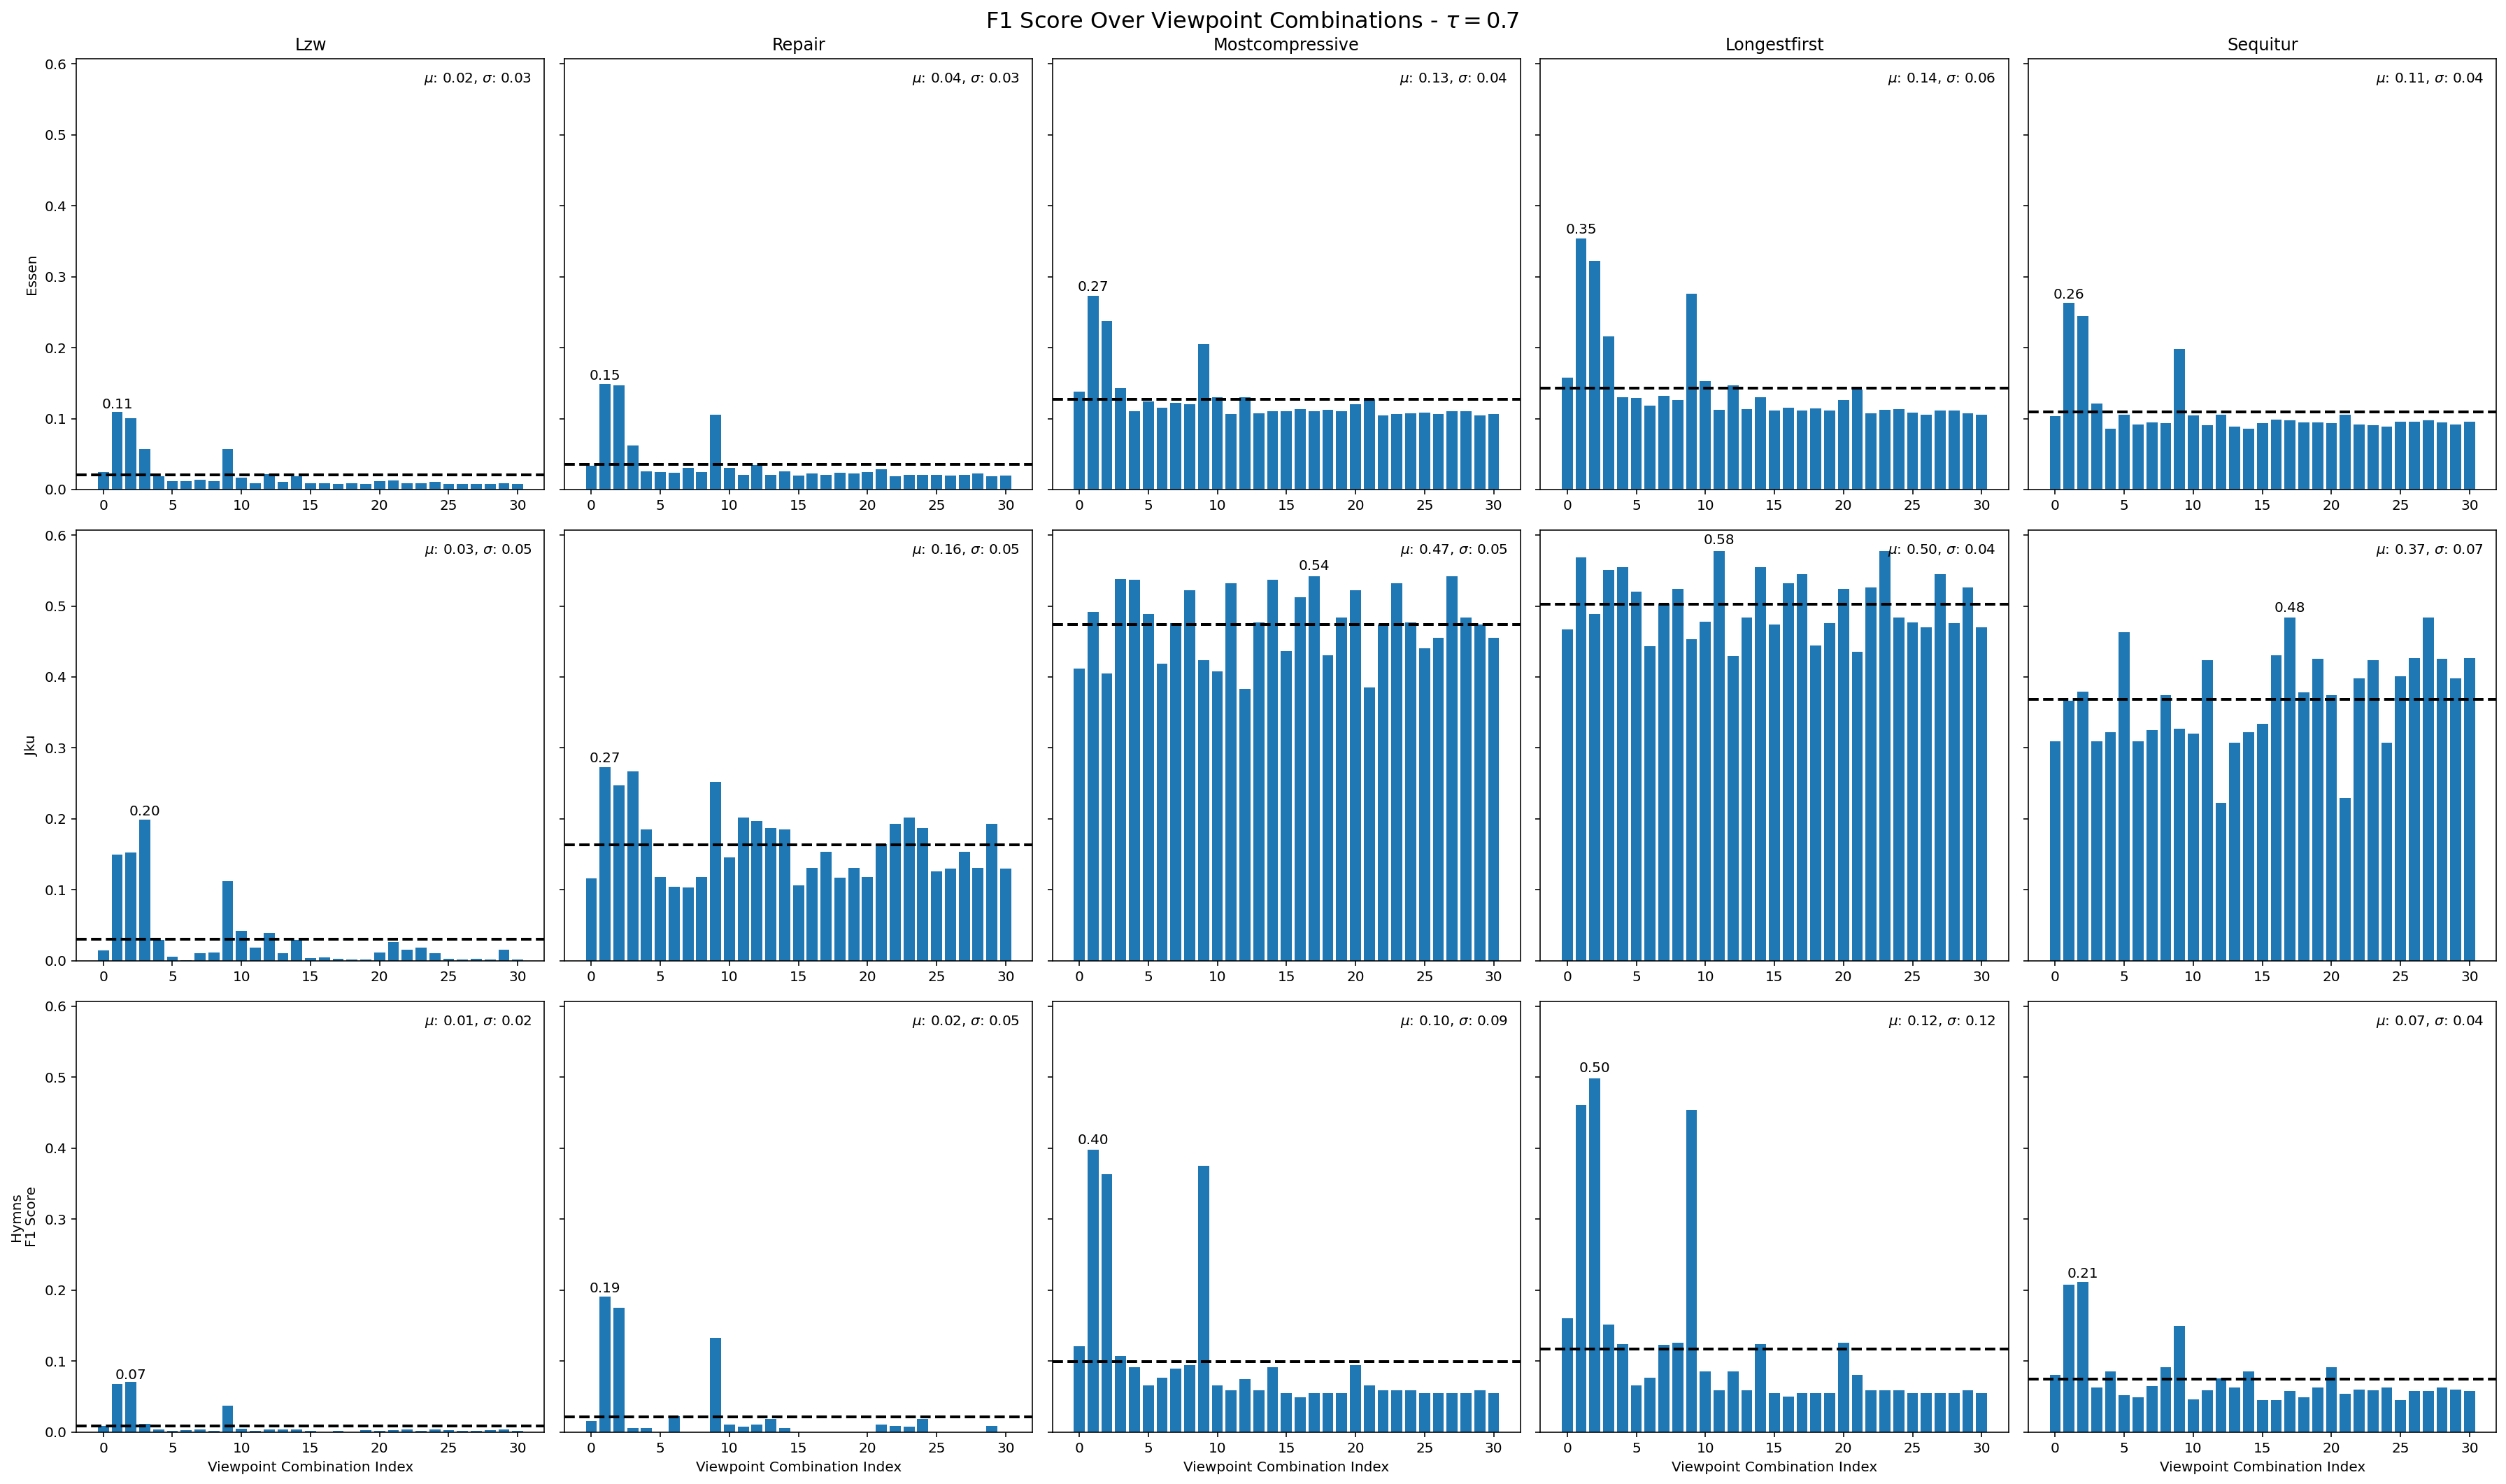

In [61]:
# Compute F-1 Score for each viewpoint combination

viewpoints = tuple(tuple(sorted(vp)) for vp in powerset(['midi', 'duration', 'interOnsetInterval', 'pitchContour', 'pitchInterval']))
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
scale = 5
fig, ax = plt.subplots(3, 5, sharey=True, figsize=(5*scale, 3*scale))
for i, dataset in enumerate(('essen', 'jku', 'hymns')):
    for j, algorithm in enumerate(('lz78', 'repair', 'mostCompressive', 'longestFirst', 'sequitur')):
        precisions = {v: [] for v in viewpoints}
        recalls = {v: [] for v in viewpoints}
        fs = {v: [] for v in viewpoints}
        pipeline = createPipeline(['../resultst70.gz'], [
            openFiles,
            toDicts,
            filterBy(lambda d: d['dataset'] == dataset and d['algorithm'] == algorithm)
        ])
        for d in pipeline:
            vp, p, r = d['viewpoints'], d['precision'], d['recall']
            precisions[vp].append(p)
            recalls[vp].append(r)
            fs[vp].append((2 * p * r) / (p + r) if p + r != 0 else 0)
        
        width = 0.35
        labels = range(1, len(viewpoints) + 1)
        x = np.arange(len(labels))
        prec = [np.mean(ps) for ps in precisions.values()]
        rec = [np.mean(rs) for rs in recalls.values()]
        rects = ax[i,j].bar(x, [np.mean(f) for f in fs.values()])

        # Annotate largest values
        maxHeight = 0
        index = 0
        heights = []
        for ii, r in enumerate(rects):
            height = r.get_height()
            heights.append(height)
            if height > maxHeight:
                maxHeight = height
                index = ii
        ax[i,j].text(rects[index].get_x() + rects[index].get_width()/2., 1.01*maxHeight, f'{maxHeight:.2f}', ha='center', va='bottom')

        # Annotation average line
        ax[i, j].axhline(np.mean(heights), color='black', linewidth=2, linestyle='--')

        # Annotate mean and std. deviation
        mu = np.mean(heights)
        sigma = np.std(heights)
        anchoredText = AnchoredText(rf'$\mu$: {mu:.2f}, $\sigma$: {sigma:.2f}', loc='upper right', frameon=False)
        ax[i, j].add_artist(anchoredText)
        # ax[i, j].annotate('Test', xy=(1, 0), xycoords='axes fraction', fontsize=16,
        #         xytext=(-5, 5), textcoords='offset points',
        #         ha='right', va='bottom')

    ax[i,0].set_ylabel(dataset.capitalize())
for j, algorithm in enumerate(('lzw', 'repair', 'mostCompressive', 'longestFirst', 'sequitur')):
    ax[0,j].set_title(algorithm.capitalize())
    ax[-1,j].set_xlabel('Viewpoint Combination Index')
ax[-1, 0].set_ylabel('F1 Score\nHymns')
fig.suptitle(r'F1 Score Over Viewpoint Combinations - $\tau = 0.7$', fontsize=16)
fig.tight_layout()
# plt.show()
plt.savefig("../figures/resultst70.png", bbox_inches='tight')


In [6]:
viewpoints = tuple(tuple(sorted(vp)) for vp in powerset(['pitch', 'duration', 'interOnsetInterval', 'pitchContour', 'pitchInterval']))
for i, vp in enumerate(viewpoints):
    print(i, '#', '{' + ', '.join(map(lambda s: s[0].upper() + s[1:], vp)) + '}') 

0 # {Pitch}
1 # {Duration}
2 # {InterOnsetInterval}
3 # {PitchContour}
4 # {PitchInterval}
5 # {Duration, Pitch}
6 # {InterOnsetInterval, Pitch}
7 # {Pitch, PitchContour}
8 # {Pitch, PitchInterval}
9 # {Duration, InterOnsetInterval}
10 # {Duration, PitchContour}
11 # {Duration, PitchInterval}
12 # {InterOnsetInterval, PitchContour}
13 # {InterOnsetInterval, PitchInterval}
14 # {PitchContour, PitchInterval}
15 # {Duration, InterOnsetInterval, Pitch}
16 # {Duration, Pitch, PitchContour}
17 # {Duration, Pitch, PitchInterval}
18 # {InterOnsetInterval, Pitch, PitchContour}
19 # {InterOnsetInterval, Pitch, PitchInterval}
20 # {Pitch, PitchContour, PitchInterval}
21 # {Duration, InterOnsetInterval, PitchContour}
22 # {Duration, InterOnsetInterval, PitchInterval}
23 # {Duration, PitchContour, PitchInterval}
24 # {InterOnsetInterval, PitchContour, PitchInterval}
25 # {Duration, InterOnsetInterval, Pitch, PitchContour}
26 # {Duration, InterOnsetInterval, Pitch, PitchInterval}
27 # {Duration, Pit

In [8]:
from pathlib import Path
resultFile = Path('../resultst80.gz')
bests = {}
for algorithm in ('lz78', 'repair', 'mostCompressive', 'longestFirst', 'sequitur'):
    print(algorithm)
    for index in range(20):
        pipeline = createPipeline([resultFile], [
            openFiles, 
            toDicts,
            filterBy(lambda d: d['dataset'] == 'hymns' and d['index'] == index and d['algorithm'] == algorithm)
        ])
        bestF1 = float('-inf')
        bestVpComb = []
        bestCompRatio = None
        for d in pipeline:
            prec = d['precision']
            rec = d['recall']
            if prec == 0 or rec == 0:
                continue
            f1 = (2 * prec * rec) / (prec + rec)
            compRatio = d['compRatio'], prec, rec
            if f1 > bestF1:
                bestF1 = f1
                bestVpComb = [d['viewpoints']]
                bestCompRatio = compRatio
            elif f1 == bestF1:
                bestVpComb.append(d['viewpoints'])
        # break
        print('\t', index, bestF1, bestVpComb, bestCompRatio)


lz78
	 0 -inf [] None
	 1 -inf [] None
	 2 -inf [] None
	 3 -inf [] None
	 4 -inf [] None
	 5 -inf [] None
	 6 0.17647058823529413 [('duration',), ('interOnsetInterval',)] (1.2307692307692308, 0.125, 0.3)
	 7 -inf [] None
	 8 -inf [] None
	 9 -inf [] None
	 10 -inf [] None
	 11 0.13333333333333333 [('midi',)] (1.7916666666666667, 0.09090909090909091, 0.25)
	 12 -inf [] None
	 13 -inf [] None
	 14 -inf [] None
	 15 0.1891891891891892 [('duration',)] (1.2857142857142858, 0.1111111111111111, 0.6363636363636364)
	 16 -inf [] None
	 17 0.3243243243243243 [('duration',)] (0.926829268292683, 0.3157894736842105, 0.3333333333333333)
	 18 -inf [] None
	 19 0.14634146341463414 [('interOnsetInterval',)] (1.4642857142857142, 0.14285714285714285, 0.15)
repair
	 0 -inf [] None
	 1 -inf [] None
	 2 0.17647058823529413 [('duration',)] (0.5405405405405406, 0.2, 0.15789473684210525)
	 3 -inf [] None
	 4 -inf [] None
	 5 -inf [] None
	 6 0.37499999999999994 [('interOnsetInterval',), ('duration',), ('durat

In [54]:
from pathlib import Path
resultFile = Path('../resultst80.gz')
bests = {}
for algorithm in ('lz78', 'repair', 'mostCompressive', 'longestFirst', 'sequitur'):
    print(algorithm)

    pipeline = createPipeline([resultFile], [
        openFiles, 
        toDicts,
        filterBy(lambda d: d['dataset'] == 'hymns' and d['index'] == 2 and d['algorithm'] == algorithm)
    ])
    bestF1 = float('-inf')
    bestVpComb = []
    for i, d in enumerate(pipeline):
        prec = d['precision']
        rec = d['recall']
        if prec == 0 or rec == 0:
            continue
        f1 = (2 * prec * rec) / (prec + rec)
        if f1 > bestF1:
            bestF1 = f1
            bestVpComb = [(d['viewpoints'], d['compRatio'], prec, rec, i)]
        elif f1 == bestF1:
            bestVpComb.append((d['viewpoints'], d['compRatio'], prec, rec, i))
    # break
    # print('\t', index, bestF1, bestVpComb)
    if not bestVpComb:
        print('None')
    else:
        print(bestVpComb[0])
        cr, prec, rec = bestVpComb[0][1:4]
        print(f'CR: {cr:.2f}, Prec: {prec}, Rec: {rec}')
        bests[algorithm] = bestVpComb[0]
bests

lz78
None
repair
(('duration',), 0.5405405405405406, 0.2, 0.15789473684210525, 1)
CR: 0.54, Prec: 0.2, Rec: 0.15789473684210525
mostCompressive
(('duration',), 0.5, 0.3333333333333333, 0.5789473684210527, 1)
CR: 0.50, Prec: 0.3333333333333333, Rec: 0.5789473684210527
longestFirst
(('duration',), 0.527027027027027, 0.6, 0.7368421052631579, 1)
CR: 0.53, Prec: 0.6, Rec: 0.7368421052631579
sequitur
(('duration',), 0.5675675675675675, 0.3333333333333333, 0.6842105263157895, 0)
CR: 0.57, Prec: 0.3333333333333333, Rec: 0.6842105263157895


{'repair': (('duration',), 0.5405405405405406, 0.2, 0.15789473684210525, 1),
 'mostCompressive': (('duration',),
  0.5,
  0.3333333333333333,
  0.5789473684210527,
  1),
 'longestFirst': (('duration',),
  0.527027027027027,
  0.6,
  0.7368421052631579,
  1),
 'sequitur': (('duration',),
  0.5675675675675675,
  0.3333333333333333,
  0.6842105263157895,
  0)}

In [9]:
from viewpoint import duration, interOnsetInterval, createViewpointFn, pitchInterval, pitchContour
from sequitur import sequitur
from lzw import lz78
from irr import repair, mostCompressive, longestFirst
from grammar import stringifyGrammar, concatify, convertGrammarToAnnotation2
import sys
sys.path.append('../src')
from pathlib import Path
hymnsPath = Path('../datasets/hymns/sequences.txt')
# from hymns import load2 as loadHymnSequences
from hymns import loadSequences
from common import formatAnnotation, parseAnnotationStr
from compare import greedyIntersection, compareLevenshteinStrict

data = loadSequences(hymnsPath)
seq = data[4]
print(seq)

gt = parseAnnotationStr('''Pattern A:
	Span 0:6
	Span 6:12
	Span 20:26
Pattern B:
	Span 12:20''')

# anns = []

# gts = [par]

for algorithm, vpFn in zip([lz78, repair, mostCompressive, longestFirst, sequitur], [duration, duration, duration, duration, duration]):
    vp = createViewpointFn([vpFn])
    vpSeq = tuple(vp(seq))
    grammar = algorithm(vpSeq)
    print(algorithm.__name__)
    # print(stringifyGrammar(grammar))
    discovered = convertGrammarToAnnotation2(grammar)
    #(discovered) = [a for a in(discovered) if len(a) > 1]
    print(formatAnnotation(enumerate(discovered)))
    P = [tuple(vpSeq[s:e] for s, e in p) for p in gt]
    Q = [tuple(vpSeq[s:e] for s, e in p) for p in discovered]
    pMatched, qMatched = greedyIntersection(compareLevenshteinStrict, 0.8, P, Q)
    precision = qMatched / len(Q)
    recall = pMatched / len(P)
    cr = len(concatify(grammar)) / len(vpSeq) 
    print(fr'CR: {cr:.2f}\nPrec: {precision}\nRec: {recall}')
    # break

Loading sequences


100%|██████████| 20/20 [00:00<00:00, 22.08it/s]

[(0.0, 67, 2.0), (2.0, 67, 1.0), (3.0, 67, 1.0), (4.0, 69, 2.0), (6.0, 69, 2.0), (8.0, 71, 1.0), (9.0, 67, 1.0), (10.0, 67, 1.0), (11.0, 69, 1.0), (12.0, 67, 2.0), (14.0, 66, 2.0), (16.0, 71, 2.0), (18.0, 71, 1.0), (19.0, 71, 1.0), (20.0, 71, 1.5), (21.5, 69, 0.5), (22.0, 69, 2.0), (24.0, 67, 1.5), (25.5, 67, 0.5), (26.0, 69, 1.0), (27.0, 67, 1.0), (28.0, 67, 2.0), (30.0, 66, 2.0), (32.0, 71, 2.0), (34.0, 67, 1.0), (35.0, 67, 1.0), (36.0, 72, 1.5), (37.5, 71, 0.5), (38.0, 69, 2.0), (40.0, 71, 1.5), (41.5, 71, 0.5), (42.0, 69, 1.0), (43.0, 67, 1.0), (44.0, 66, 1.0), (45.0, 64, 1.0), (46.0, 62, 2.0), (48.0, 71, 2.0), (50.0, 67, 1.0), (51.0, 69, 1.0), (52.0, 67, 2.0), (54.0, 66, 2.0), (56.0, 67, 4.0)]
lz78
Pattern 1:
	Span 0:1
Pattern 2:
	Span 1:2
Pattern 3:
	Span 2:4
Pattern 4:
	Span 4:6
Pattern 5:
	Span 6:8
Pattern 6:
	Span 8:11
Pattern 7:
	Span 11:14
Pattern 8:
	Span 14:15
Pattern 9:
	Span 15:16
Pattern 10:
	Span 16:18
Pattern 11:
	Span 18:20
Pattern 12:
	Span 20:24
Pattern 13:
	Span 2

In [25]:
# Compute average length of each sequence for each dataset
from common import gzPickleIter

datasets = [
    gzPickleIter('../datasets/essen/essen300.pkl.gz'),
    gzPickleIter('../datasets/jku/jku.pkl.gz'),
    gzPickleIter('../datasets/hymns/hymns.pkl.gz')
]

lengths = []
for d in datasets:
    lengths.append([len(x[0]) for x in d])
#     lengths.append([len(x) for x in d.items()])

print('Dataset, Mean Sequence Length, Standard Deviation')
for l, dataset in zip(lengths, ('Essen', 'Jku', 'Hymns')):
    print(f'{dataset}, {np.mean(l):.2f}, {np.std(l):.2f}')

Dataset, Mean Sequence Length, Standard Deviation
Essen, 64.22, 29.60
Jku, 677.20, 189.08
Hymns, 45.11, 16.29


Text(0.5, 0.98, 'Number of Patterns vs Span Length')

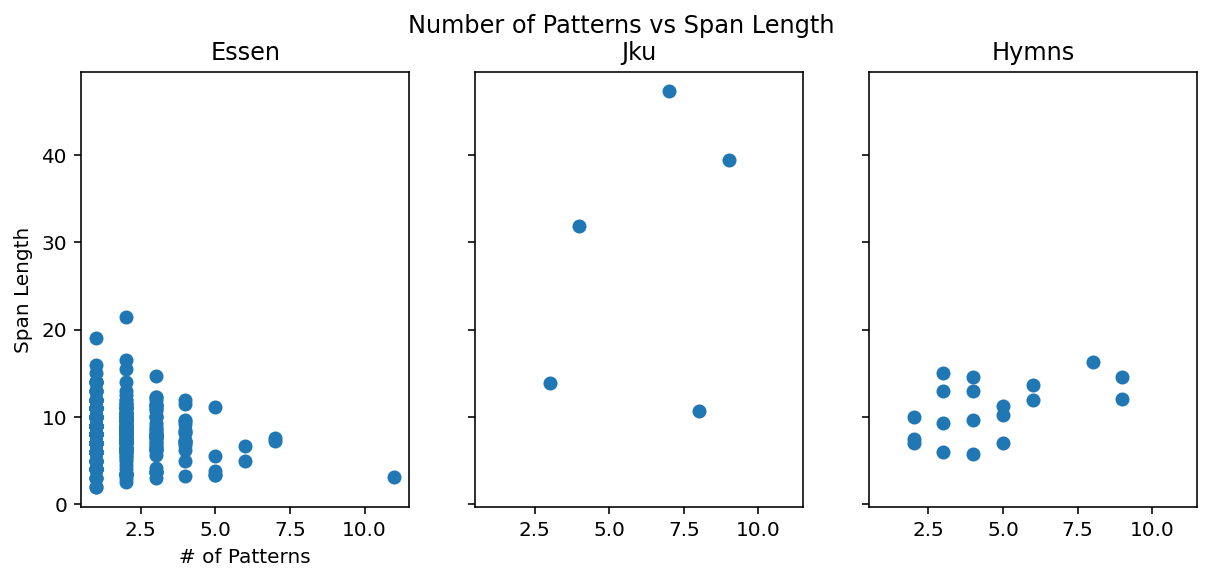

In [53]:
# Compute pattern length vs span length
from common import gzPickleIter

datasets = [
    gzPickleIter('../datasets/essen/essen300.pkl.gz'),
    gzPickleIter('../datasets/jku/jku.pkl.gz'),
    gzPickleIter('../datasets/hymns/hymns.pkl.gz')
]

allLengths = []
for d in datasets:
    lengths = []
    for x in d:
        patterns = x[1]
        avgSpanLength = np.mean([e-s for p in patterns for s, e in p])
        lengths.append((len(patterns), avgSpanLength))
    allLengths.append(lengths)

fig, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True)
x, y = zip(*allLengths[0])
ax[0].scatter(x, y)
ax[0].set_title('Essen')
ax[0].set_ylabel('Span Length')
ax[0].set_xlabel('# of Patterns')
x, y = zip(*allLengths[1])
ax[1].scatter(x, y)
ax[1].set_title('Jku')
x, y = zip(*allLengths[2])
ax[2].scatter(x, y)
ax[2].set_title('Hymns')
fig.suptitle('Number of Patterns vs Span Length')

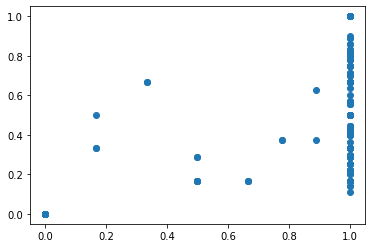

In [94]:
dataset = 'hymns'
algorithm = 'repair'
pipeline = createPipeline(['../lsresults.gz'], [
    openFiles,
    toDicts,
    filterBy(lambda d: d['algorithm'] == algorithm and d['dataset'] == dataset and d['viewpoints'] == ('duration',))
])

precs = []
recs = []
for d in pipeline:
    precs.append(d['precision'])
    recs.append(d['recall'])
fig, ax = plt.subplots()
ax.scatter(recs, precs)


/tmp/ipykernel_234/1832512130.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


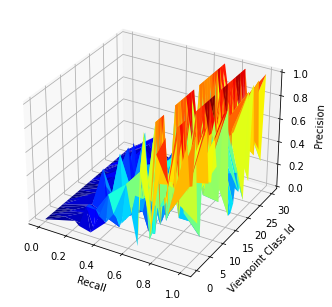

In [91]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt, cm
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(rs, vs, ps, cmap=cm.jet)
ax.set_xlabel('Recall')
ax.set_ylabel('Viewpoint Class Id')
ax.set_zlabel('Precision')
# ax.invert_xaxis()
# # ax.invert_yaxis()
# ax.zaxis.set_rotate_label(False)
# ax.azim = 110
# ax.elev = 10
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fns = [
    openFiles,
    toDicts,
    filterBy(lambda d: d['algorithm'] == 'longestFirst'),
    filterBy(lambda d: d['dataset'] == 'essen'),
    filterBy(lambda d: d['viewpoints'] == ('duration',)),
    apply(lambda d: (d['precision'], d['recall'])),
    unpack
]

precisions, recalls = createPipeline(['../results.gz'], fns)
print(len(precisions), len(recalls))
fig, ax = plt.subplots()
ax.hist(recalls)


In [ ]:
def plotPRCurve(ax, data1, data2, params={}):
    out = ax.scatter(data1, data2, **params)
    return out

def plotPRHist(ax, data, params={}):
    out = ax.hist(data, **params)
    return out

# Create B&W plot for P&R for each alg on each dataset
def plotBW(ax, data, params={}):
    out = ax.boxplot(data, **params)
    return out

In [ ]:
def getPrecisionAndRecall(filename, algorithm, dataset):
    precisions, recalls = createPipeline([filename], [
        openFiles,
        toDicts,
        filterBy(lambda d: d['algorithm'] == algorithm and d['dataset'] == dataset),
        apply(lambda d: (d['precision'], d['recall'])),
        unpack
    ])
    return precisions, recalls

In [30]:
import numpy as np
thresholds = getThresholds('../blstrictresults.gz', 'longestFirst', 'hymns')
print(thresholds.keys())
for t in sorted(thresholds):
    print(t, np.mean(thresholds[t]))

dict_keys([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.0, 0.1, 0.2, 0.3])
0.0 0.9762308998302207
0.1 0.5159969817015657
0.2 0.4862856064893416
0.3 0.44042633465383896
0.4 0.3637662705149972
0.5 0.31975570647047724
0.6 0.23487549518958686
0.7 0.16012544802867384
0.8 0.11685531031880778
0.9 0.08058856819468026
1.0 0.020118845500848897
